# Triangle Meshes

This notebook demonstrates the application of `circle_bundles` to a synthetic dataset of 3D densities constructed from ...


In [1]:
# ============================================================
# Core scientific stack
# ============================================================
import numpy as np
import matplotlib.pyplot as plt


# ============================================================
# circle_bundles core API
# ============================================================
import circle_bundles as cb
import circle_bundles.synthetic as sy
import circle_bundles.viz as vz


In [2]:
from __future__ import annotations

def mesh_vertex_normals(
    X: np.ndarray,
    *,
    n_vertices: int | None = None,
    vertex_dim: int = 3,
    idx: tuple[int, int, int] = (0, 1, 2),
    eps: float = 1e-12,
) -> np.ndarray:
    """
    Compute the oriented unit normal determined by three vertices
    from flattened mesh-vertex data.

    Raises a ValueError if any triple is colinear or degenerate.

    Parameters
    ----------
    X:
        Shape (D,) for one mesh or (N, D) for batch.
    n_vertices:
        Optional expected vertex count.
    vertex_dim:
        Usually 3.
    idx:
        (i, j, k) vertex indices used.
        Orientation follows cross(vj-vi, vk-vi).
    eps:
        Tolerance for detecting degeneracy.

    Returns
    -------
    normals:
        Shape (3,) or (N,3) of unit normals.
    """
    X = np.asarray(X)
    single = (X.ndim == 1)

    if single:
        Xb = X[None, :]
    elif X.ndim == 2:
        Xb = X
    else:
        raise ValueError(f"X must be 1D or 2D. Got shape {X.shape}.")

    N, D = Xb.shape

    if D % vertex_dim != 0:
        raise ValueError(f"D={D} not divisible by vertex_dim={vertex_dim}.")

    nv = D // vertex_dim
    if n_vertices is not None and nv != int(n_vertices):
        raise ValueError(f"Expected {n_vertices} vertices, got {nv}.")

    i, j, k = map(int, idx)
    if not (0 <= i < nv and 0 <= j < nv and 0 <= k < nv):
        raise ValueError(f"indices {idx} out of range for nv={nv}")

    V = Xb.reshape(N, nv, vertex_dim)

    a = V[:, i]
    b = V[:, j]
    c = V[:, k]

    u = b - a
    v = c - a

    n = np.cross(u, v)
    norm = np.linalg.norm(n, axis=1)

    # Strict check
    bad = norm <= eps
    if np.any(bad):
        inds = np.where(bad)[0]
        raise ValueError(
            f"Colinear or degenerate vertex triples encountered at indices: {inds[:10]}"
            + (" ..." if len(inds) > 10 else "")
        )

    normals = n / norm[:, None]

    if single:
        return normals[0]
    return normals


First, generate a dataset of triangle meshes, stored as vectors of length $3\times 6 = 18$:

In [38]:
#Create the template triangle mesh

#mesh, face_groups = sy.make_tri_prism(height=1, radius=1)
mesh = sy.make_star_pyramid(n_points = 5, height = 1)

#Create a visualization function
#vis_mesh = sy.make_tri_prism_visualizer(mesh, face_groups)
vis_mesh = sy.make_star_pyramid_visualizer(mesh)

In [39]:
n_samples = 5000
rng = np.random.default_rng(0)
R = sy.sample_so3(n_samples, rng=rng)[0]

data = sy.get_mesh_sample(mesh, R)

View a small sample of the dataset:

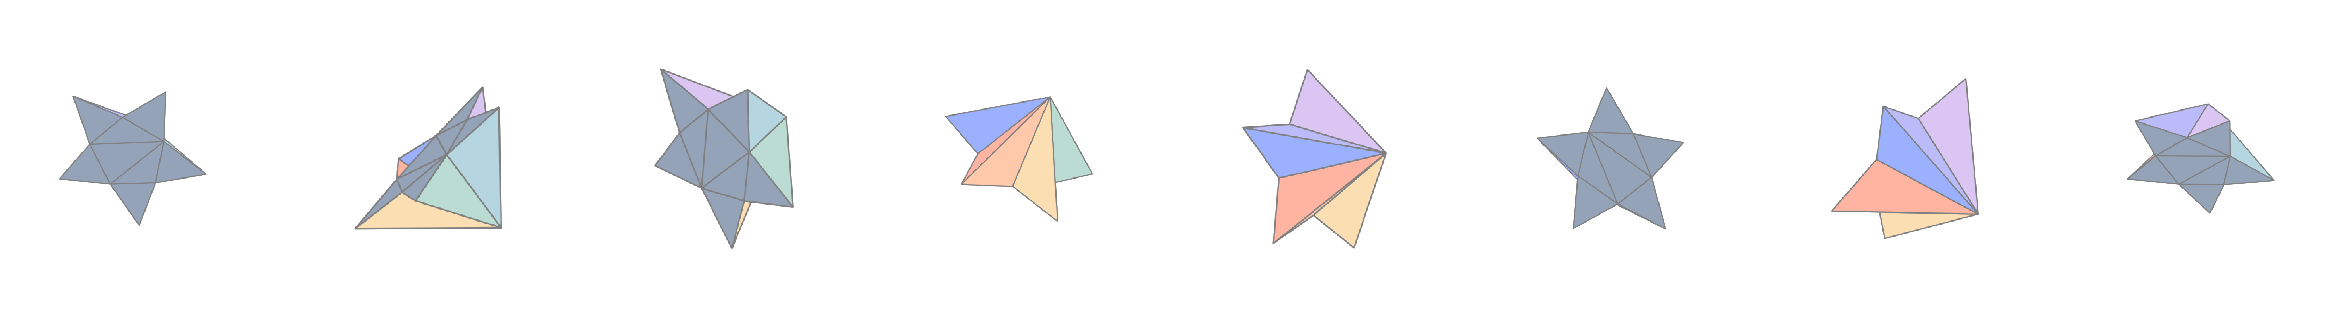

In [40]:
fig = vz.show_data_vis(
    data, 
    vis_mesh, 
    max_samples=8, 
    n_cols=8, 
    sampling_method="first", 
    pad_frac=0.3)
plt.show()


Compute the base projections to $\mathbb{S}^{2}$:

In [41]:
base_points = mesh_vertex_normals(
    data,
    vertex_dim = 3,
    idx = (0, 1, 2), #choose vertices to use for projection
)

Construct an open cover of $\mathbb{S}^{2}$ using a collection of nearly equidistant landmark points (see reference section):

### Cover And Nerve Summary
- $n_\text{sets} = 60$, $n_\text{samples} = 5000$

**Recorded Simplex Counts:**

- $\#(\text{0-simplices}) = 60$
- $\#(\text{1-simplices}) = 174$
- $\#(\text{2-simplices}) = 116$
- *No recorded simplices in dimensions* $\ge 3$

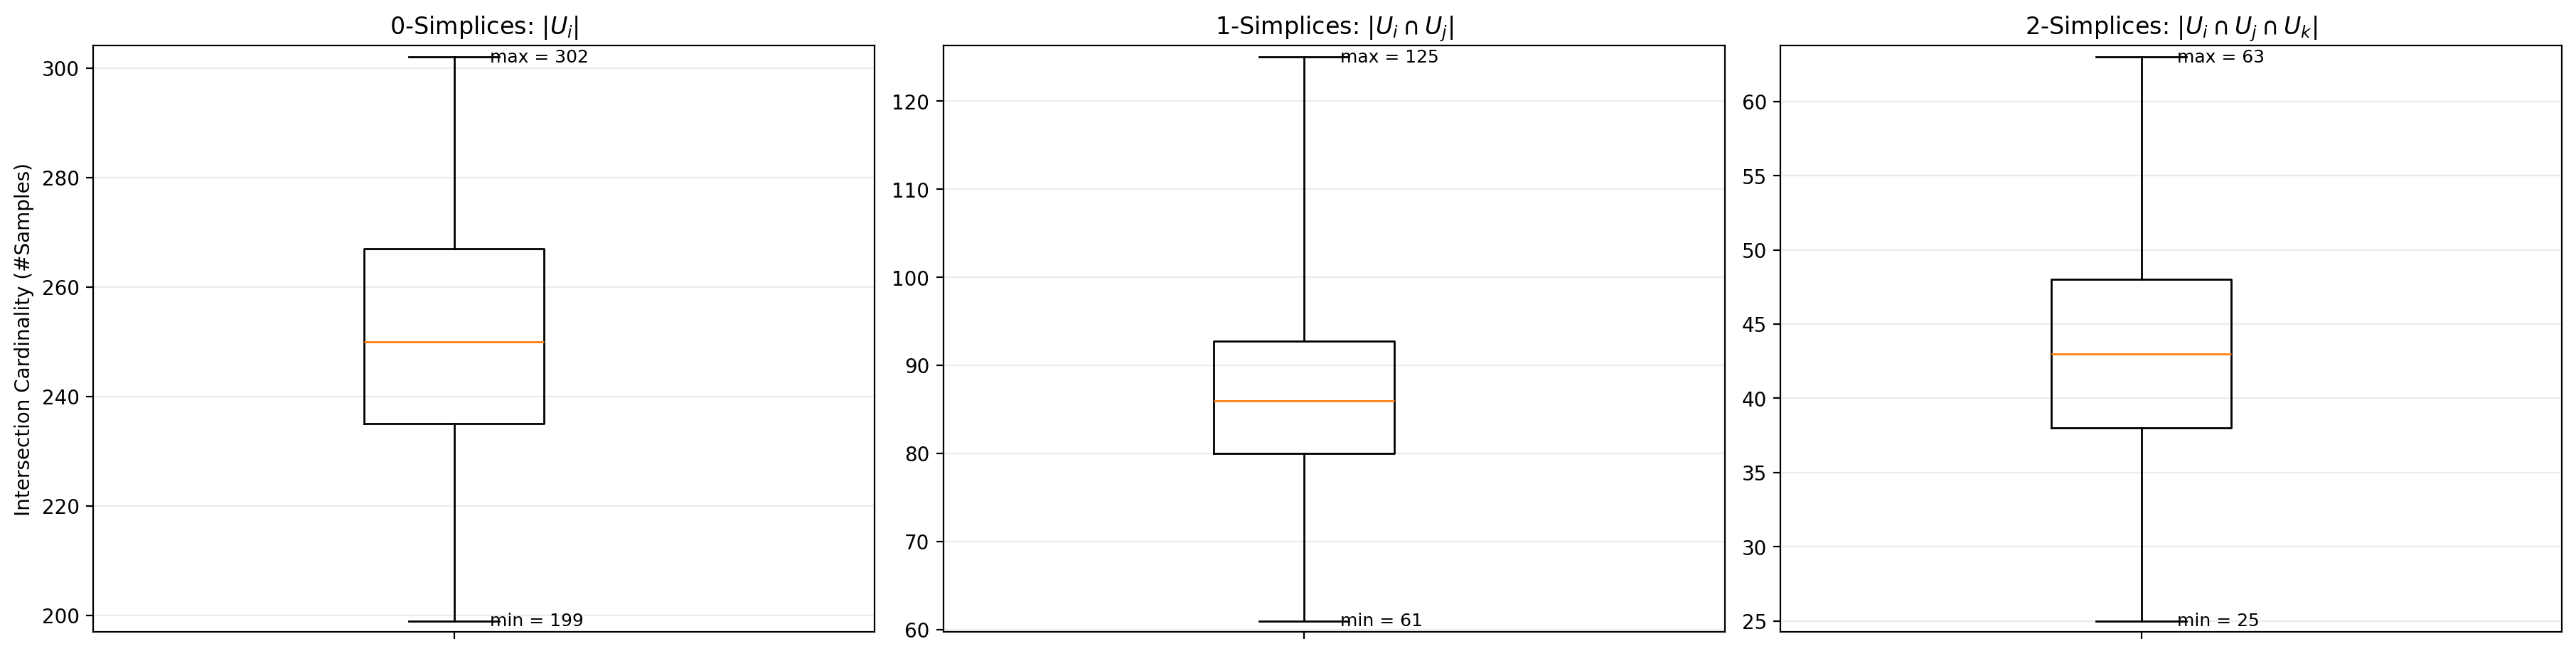

In [42]:
n_landmarks = 60
cover = cb.make_s2_fibonacci_star_cover(base_points, n_vertices = n_landmarks)

summ = cover.summarize(plot = True)

Optionally run the cell below to view a Plotly visualization of the nerve of the open cover:

In [43]:
fig = cover.show_nerve()

Compute a persistence diagram for the data in each set $\pi^{-1}(U_{j})$

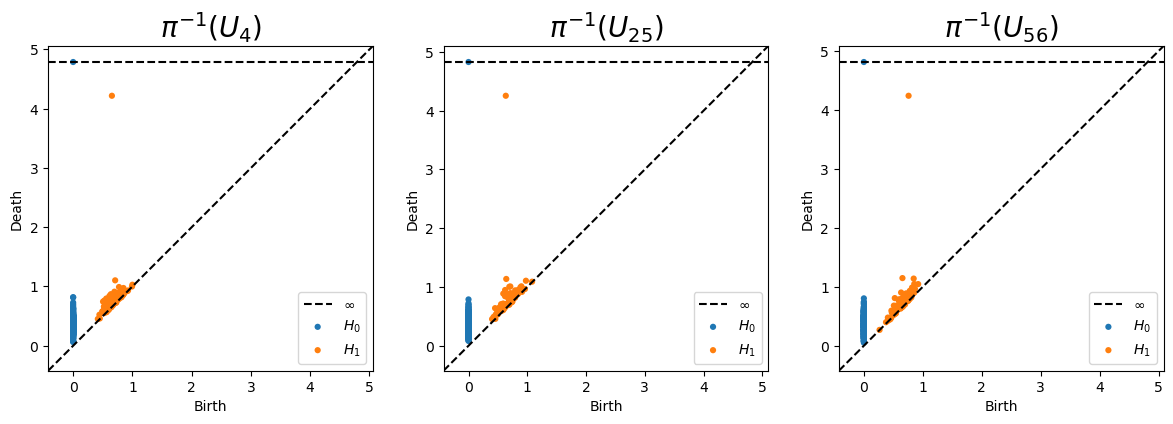

In [44]:
fiber_ids, dense_idx_list, rips_list = cb.get_local_rips(
    data,
    cover.U,
    to_view = [4,25,56], #Choose a few diagrams to compute 
                       #(or compute all by setting to None)
    maxdim=1,
    n_perm=500,
    random_state=None,
)

fig, axes = cb.plot_local_rips(
    fiber_ids,
    rips_list,
    n_cols=3,
    titles='default',
    font_size=20,
)

Optionally run the cell below to show a visualization of an interactive visualization of the projection map:

In [45]:
app = vz.show_bundle_vis(base_points = base_points, data = data)

Bundle viewer running at: http://127.0.0.1:52143/


Compute local circular coordinates, approximate transition matrices and characteristic clases

In [46]:
bundle = cb.build_bundle(
    data,
    cover,
    show=True,                          
)


<IPython.core.display.Math object>

Now, restrict the bundle to the equator $\mathbb{S}^{1}\subset \mathbb{S}^{2}$:

In [47]:
eps = 0.15  # thickness of equatorial band (in the chosen S^2 embedding/coords)

# Points near the equator: last coordinate close to 0
eq_mask = np.abs(base_points[:, -1]) < eps

eq_data = bundle.data[eq_mask]

# Parametrize the equator by an angle in S^1 
eq_base_angles = np.arctan2(base_points[eq_mask, 1], base_points[eq_mask, 0]) % (2*np.pi)

print(f"Equator band: {eq_data.shape[0]} / {bundle.data.shape[0]} samples (eps={eps}).")

Equator band: 698 / 5000 samples (eps=0.15).


Constuct an open cover of $\mathbb{S}^{1}$ by metric balls around equally-spaced landmark points:

### Cover And Nerve Summary
- $n_\text{sets} = 12$, $n_\text{samples} = 698$

**Recorded Simplex Counts:**

- $\#(\text{0-simplices}) = 12$
- $\#(\text{1-simplices}) = 12$
- *No recorded simplices in dimensions* $\ge 2$

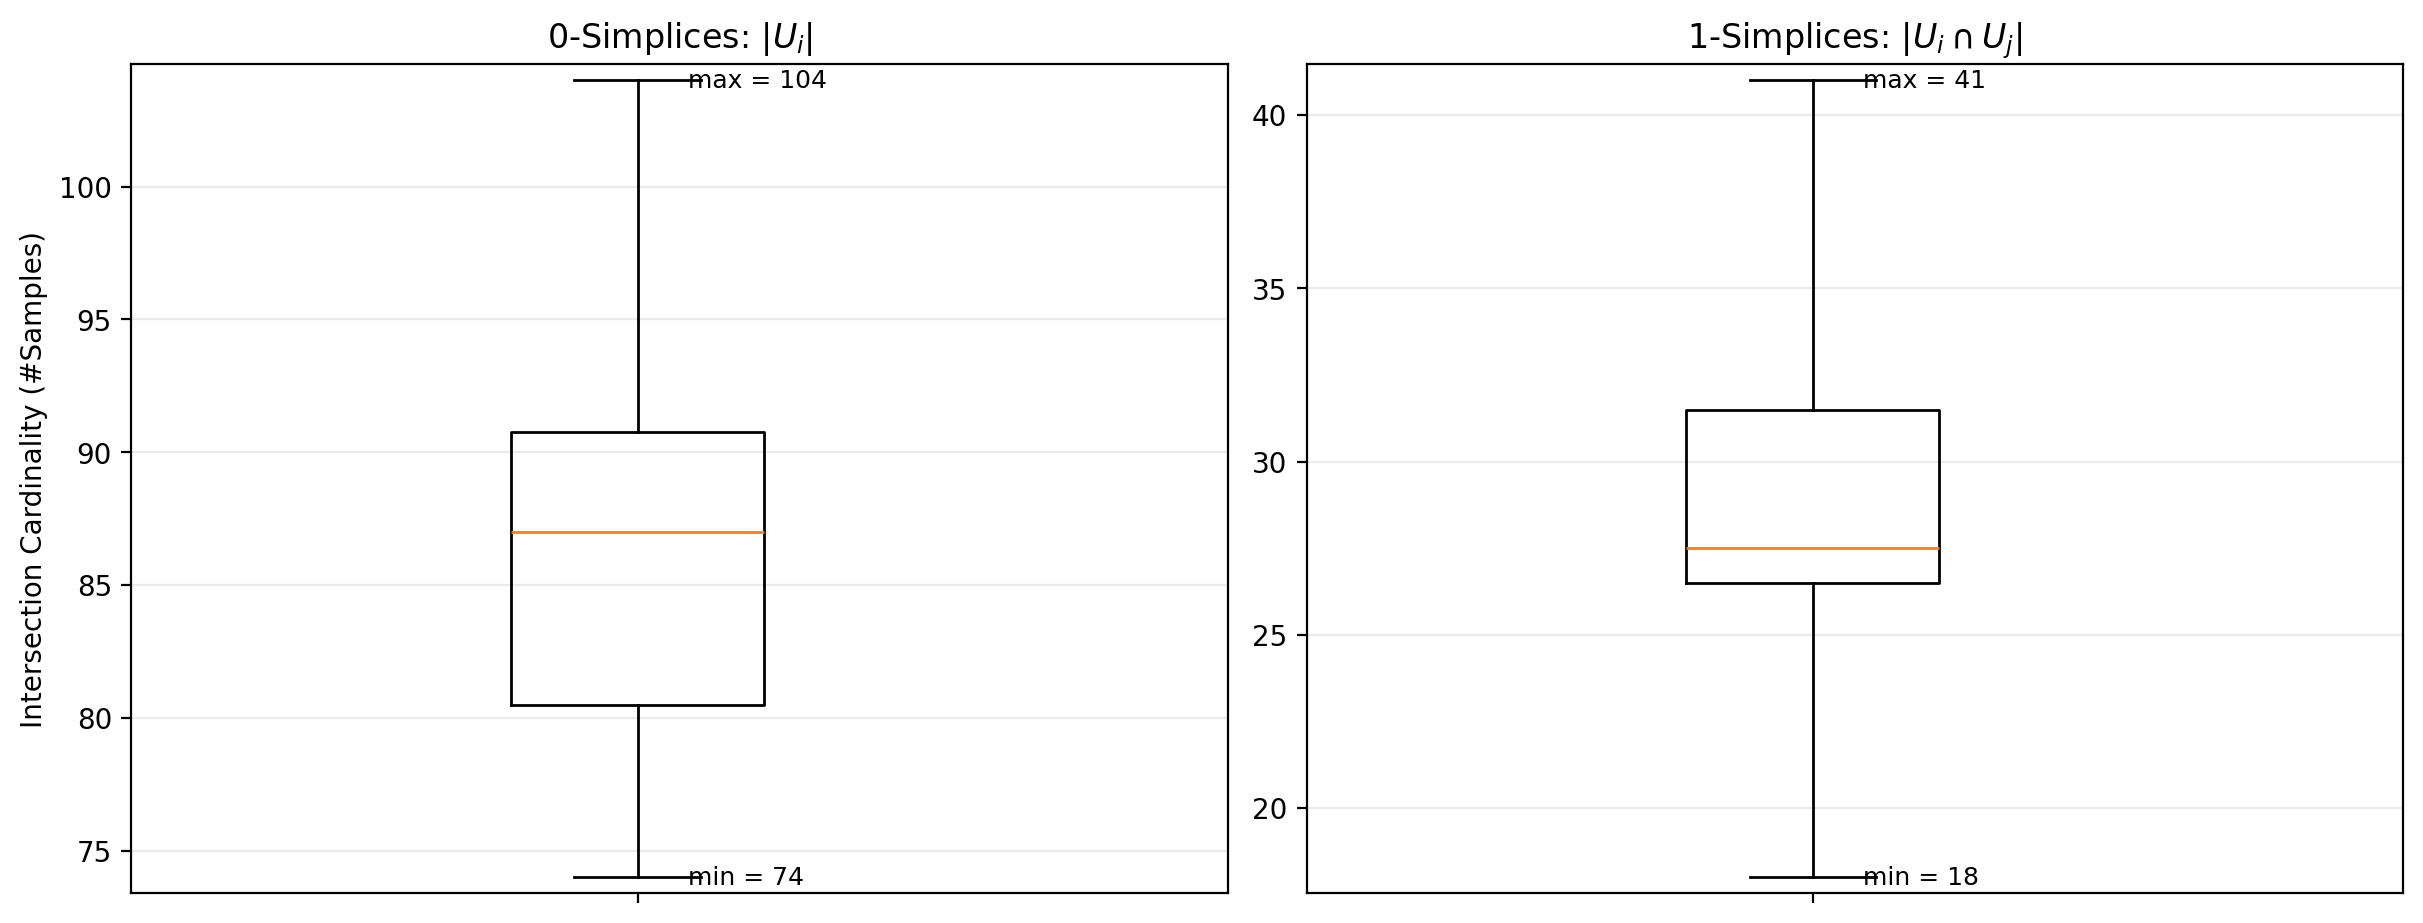

In [48]:
n_landmarks = 12
landmarks = np.linspace(0, 2*np.pi, n_landmarks, endpoint=False)

overlap = 1.5
radius = overlap * np.pi / n_landmarks

eq_cover = cb.MetricBallCover(
    eq_base_angles,
    landmarks,
    radius,
    metric=cb.S1AngleMetric(),
)
eq_cover_data = eq_cover.build()

#Show a summary of the construction
eq_summ = eq_cover.summarize(plot = True)

Compute characteristic classes for the restricted bundle:

In [49]:
eq_bundle = cb.build_bundle(
    eq_data,
    eq_cover,
    show=True,
)


<IPython.core.display.Math object>

Observe that the restricted bundle is orientable, hence trivial, as expected. Construct a global toroidal coordinate system by synchronizing local circular coordinates:

In [50]:
eq_triv_result = eq_bundle.get_global_trivialization()

Finally, show a visualization of the coordinatized meshes:

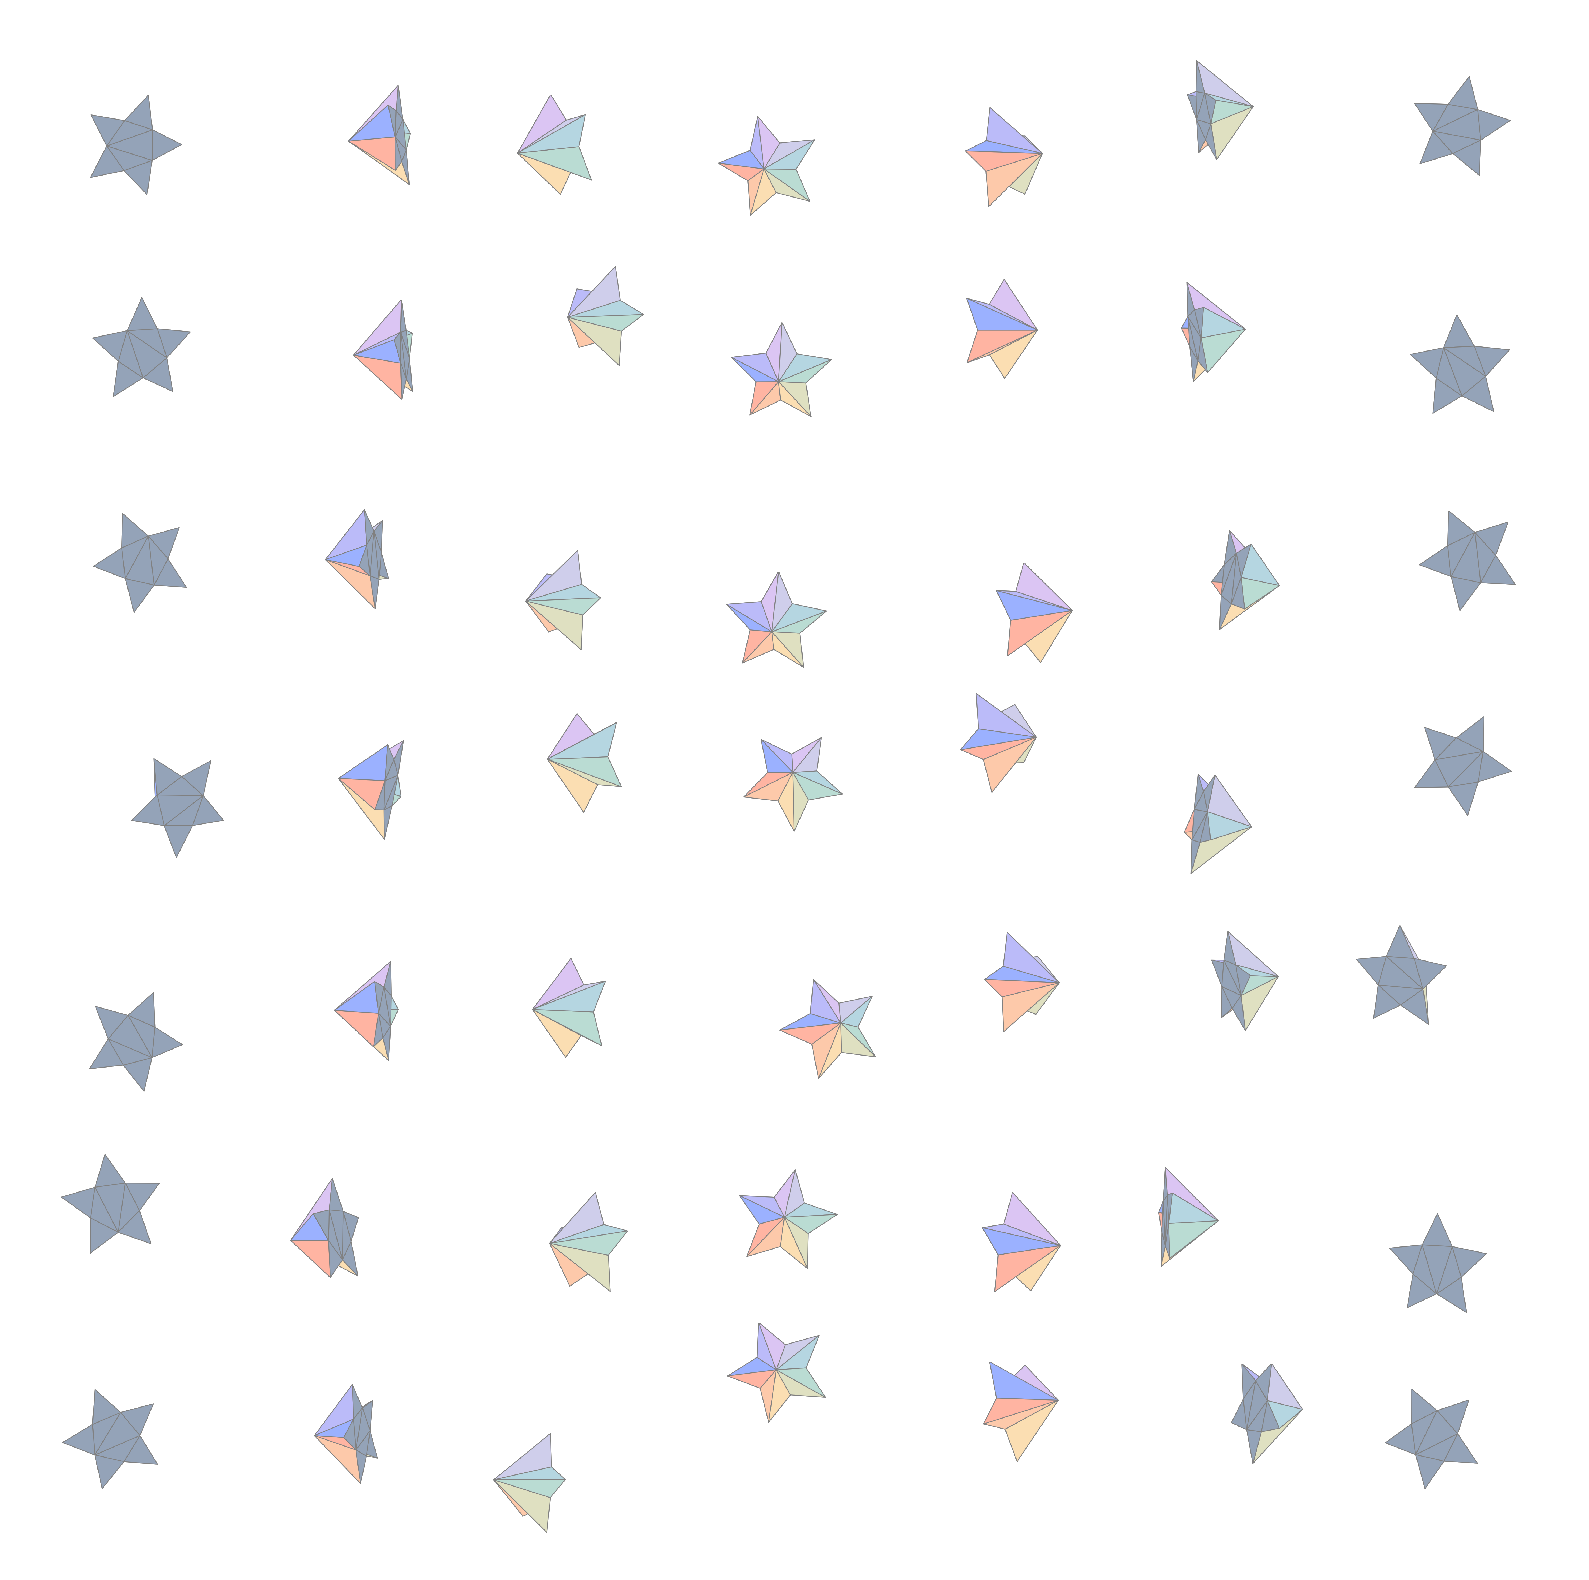

In [51]:
coords = np.column_stack([eq_base_angles, eq_triv_result.F])

fig = vz.lattice_vis(
    eq_data,
    coords,
    vis_mesh,
    per_row=7,
    per_col=7,
    figsize=10,
    thumb_px=100,
    dpi=200,
)

plt.show()


Base projection angle varies from $0$ to $2\pi$ along the $x$-direction and fiber angle varies from $0$ to $2\pi$ along the $y$-direction.  Notice that base projection roughly corresponds to axis of symmetry, as expected.  The coordinatized meshes in each column approximately traverse a full rotation about the axis of symmetry. Meshes on opposite edges of the diagram roughly correspond, reflecting the toroidal topology of the restricted dataset. 